
|평가문항|상세기준|
|:--|:--|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터셋 구축

In [2]:
(ds_train, ds_val, ds_test), info = tfds.load(
    'stanford_dogs',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/aiffel/tensorflow_datasets/stanford_dogs/0.2.0',
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature

In [5]:
#train, val, test 개수 확인
len(ds_train),len(ds_val),len(ds_test)

(10800, 1200, 8580)

In [3]:
# class 확인
num_classes = info.features["label"].num_classes
num_classes

120

In [28]:
info.features["label"]

ClassLabel(shape=(), dtype=tf.int64, num_classes=120)

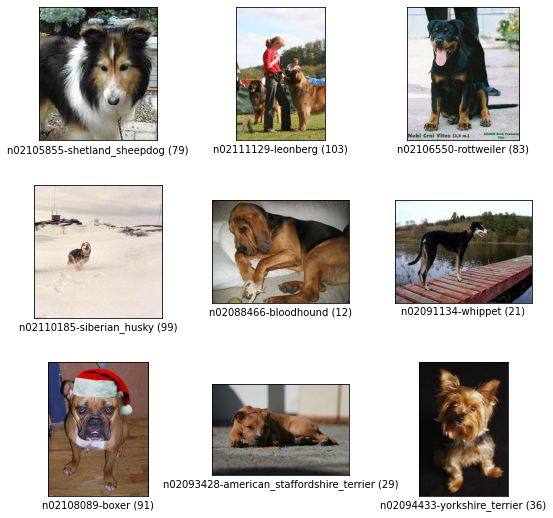

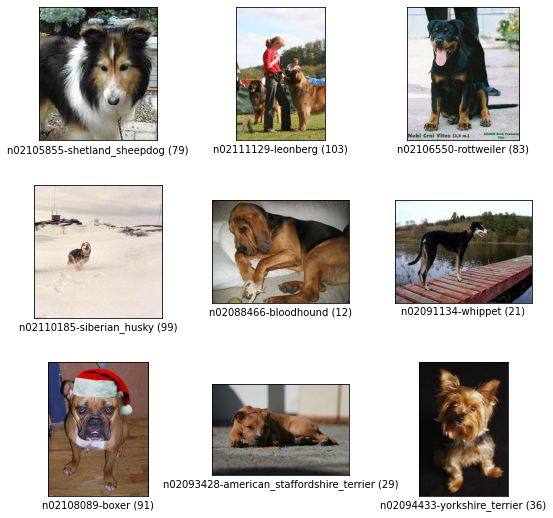

In [6]:
tfds.show_examples(ds_train, info)

### 데이터 확인

In [7]:
sample = ds_train.take(1)

In [8]:
smp_img, smp_y = None, None
for s in sample: 
    smp_img = s['image']
    smp_y = s['label']
smp_y

<tf.Tensor: shape=(), dtype=int64, numpy=83>

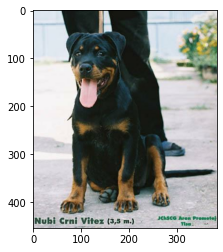

In [9]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(smp_img))

In [5]:
import math

In [4]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
#     print('augment')
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def augment2(image, label):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    image = tf.image.random_contrast(image, 1/1.3, 1.3)
    image = tf.image.random_hue(image, 0.1)
#     image = tf.keras.preprocessing.image.random_rotation(image, 90)

#     random_height = tf.random.uniform((), minval=32, maxval=40, dtype=tf.int32)
#     random_width = tf.random.uniform((), minval=32, maxval=40, dtype=tf.int32)
#     image = tf.image.resize(image, (random_height, random_width))
#     image = tf.image.random_crop(image, (32, 32, 3))
    return image, label

In [7]:
def plot_aug(col,row,aug, img, y):
    plt.figure(0, figsize=(15, 15))
    plots = []
    for i in range(row):
        for j in range(col):
            image, label = normalize_and_resize_img(img, y)
            image, label = aug(img, y)
            image = tf.keras.preprocessing.image.array_to_img(image)
            ax = plt.subplot2grid((row,col), (i,j))
            ax.imshow(image)
    plt.show() 

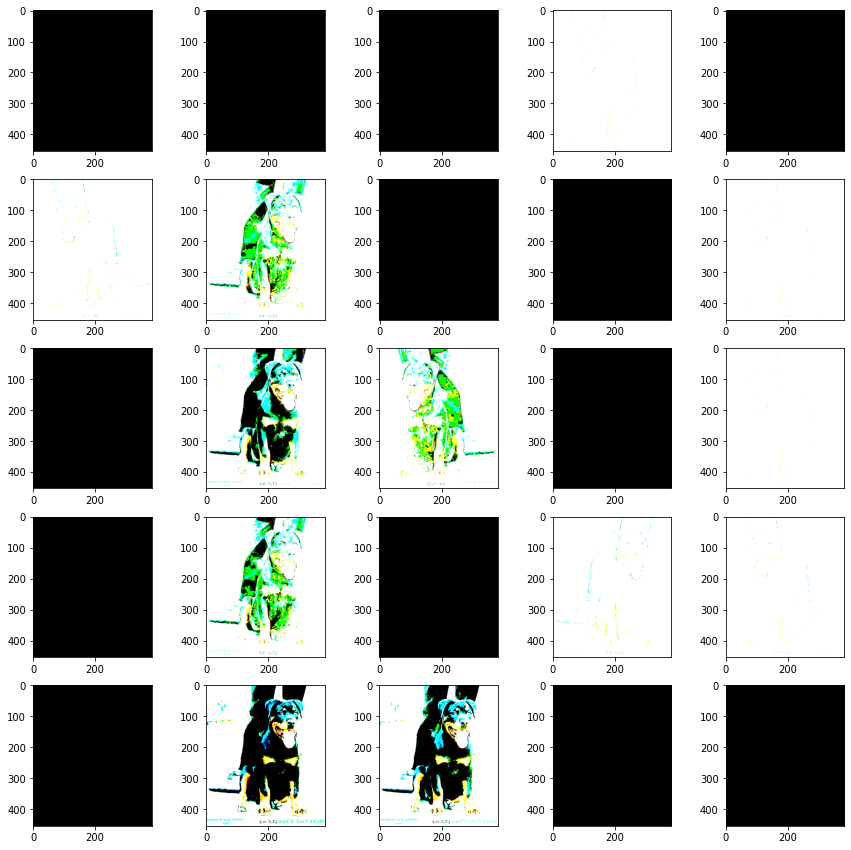

In [14]:
plot_aug(5, 5, augment, smp_img, smp_y)

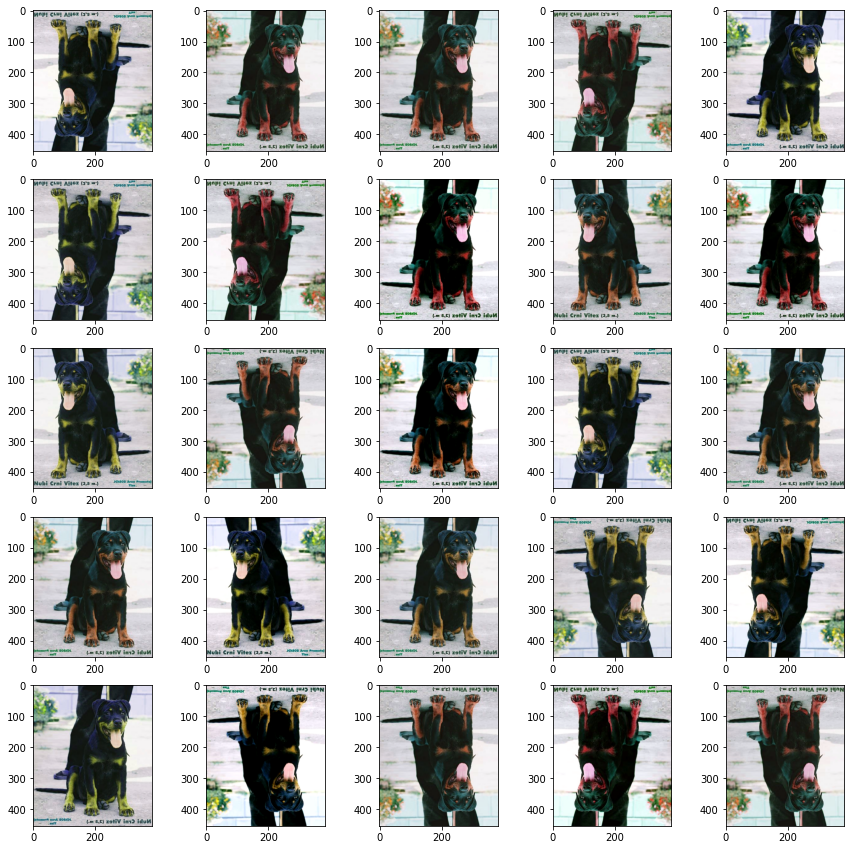

In [22]:
plot_aug(5, 5, augment2, smp_img, smp_y)

### 전처리

In [5]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    # 일반 aug 적용
    if not is_test and with_aug:
        ds = ds.map(
            augment2
        )
    ds = ds.batch(batch_size)
    
    # cutmix, mixup은 batch 후에 적용
    # cutmix 적용
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    # mixup 적용
    elif not is_test and with_mixup:  
        ds = ds.map(
            mixup,
            num_parallel_calls=2)
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
            
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
            
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_val = apply_normalize_on_dataset(ds_val, is_test=False)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### CutMix

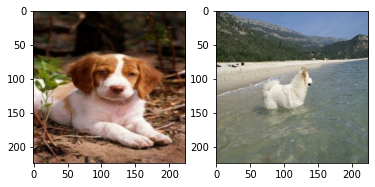

In [7]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [8]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(126, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(35, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


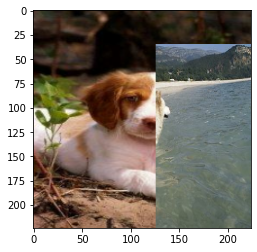

In [9]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [15]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.7405134 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [10]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### MixUp

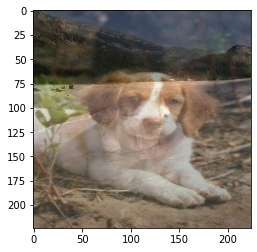

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.5337235  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [11]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [12]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 모델 구축

In [19]:
# base resnet-50 사용
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [13]:
EPOCH = 20 

### (1) Resnet-50

In [21]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(info.splits['train'].num_examples/16),
    validation_steps=int(info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 168s 209ms/step - loss: 2.1757 - accuracy: 0.4588 - val_loss: 3.5458 - val_accuracy: 0.1920
Epoch 2/20
750/750 [==============================] - 161s 214ms/step - loss: 0.6365 - accuracy: 0.8310 - val_loss: 1.0936 - val_accuracy: 0.6695
Epoch 3/20
750/750 [==============================] - 160s 214ms/step - loss: 0.1698 - accuracy: 0.9716 - val_loss: 0.9753 - val_accuracy: 0.7095
Epoch 4/20
750/750 [==============================] - 160s 214ms/step - loss: 0.0464 - accuracy: 0.9972 - val_loss: 0.9715 - val_accuracy: 0.7210
Epoch 5/20
750/750 [==============================] - 160s 214ms/step - loss: 0.0334 - accuracy: 0.9985 - val_loss: 0.9755 - val_accuracy: 0.7222
Epoch 6/20
750/750 [==============================] - 160s 214ms/step - loss: 0.0227 - accuracy: 0.9994 - val_loss: 1.0083 - val_accuracy: 0.7153
Epoch 7/20
750/750 [==============================] - 161s 214ms/step - loss: 0.0146 - accuracy: 0.9996 - val_loss: 0.9915 -

In [23]:
del ds_train_no_aug

In [22]:
loss, accuracy = resnet50.evaluate(ds_test)
resnet50.save('resnet50_no_aug.hdf5')
del resnet50
print('Resnet-50 plain')
print(f"Loss: {loss},\nAccuracy: {accuracy}")

537/537 [==============================] - 29s 53ms/step - loss: 1.0639 - accuracy: 0.7297


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Resnet-50 plain
Loss: 1.0639146566390991,
Accuracy: 0.7297202944755554


In [24]:
import pickle

In [27]:
with open('history_resnet50_no_aug.pickle','wb') as f:
    pickle.dump(history_resnet50_no_aug.history,f)
    
del history_resnet50_no_aug

### (2) Resnet-50 with general augmentation

In [28]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

In [33]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = resnet50.fit(
    ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(info.splits['train'].num_examples/16),
    validation_steps=int(info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 170s 215ms/step - loss: 2.8569 - accuracy: 0.3075 - val_loss: 2.8835 - val_accuracy: 0.2668
Epoch 2/20
750/750 [==============================] - 160s 214ms/step - loss: 1.5144 - accuracy: 0.5741 - val_loss: 1.7728 - val_accuracy: 0.5077
Epoch 3/20
750/750 [==============================] - 160s 214ms/step - loss: 1.0341 - accuracy: 0.7017 - val_loss: 1.5724 - val_accuracy: 0.5476
Epoch 4/20
750/750 [==============================] - 160s 214ms/step - loss: 0.7647 - accuracy: 0.7814 - val_loss: 1.2899 - val_accuracy: 0.6049
Epoch 5/20
750/750 [==============================] - 160s 214ms/step - loss: 0.5359 - accuracy: 0.8487 - val_loss: 1.5634 - val_accuracy: 0.5800
Epoch 6/20
750/750 [==============================] - 161s 214ms/step - loss: 0.3895 - accuracy: 0.8971 - val_loss: 1.2630 - val_accuracy: 0.6428
Epoch 7/20
750/750 [==============================] - 160s 214ms/step - loss: 0.2694 - accuracy: 0.9356 - val_loss: 1.7608 -

In [34]:
del ds_train_aug
loss, accuracy = resnet50.evaluate(ds_test)
resnet50.save('resnet50_aug.hdf5')

print('Resnet-50 with aug')
print(f"Loss: {loss},\nAccuracy: {accuracy}")

with open('history_resnet50_aug.pickle','wb') as f:
    pickle.dump(history_resnet50_aug.history,f)
    
# del history_resnet50_aug
# del resnet50

537/537 [==============================] - 28s 52ms/step - loss: 1.2810 - accuracy: 0.6848
Resnet-50 with aug
Loss: 1.2810077667236328,
Accuracy: 0.6848484873771667


In [35]:
del history_resnet50_aug
del resnet50

### (3) Resnet-50 with cutmix

In [30]:
ds_train_cm = apply_normalize_on_dataset(ds_train, with_cutmix=True)

In [31]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cm = resnet50.fit(
    ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(info.splits['train'].num_examples/16),
    validation_steps=int(info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 173s 220ms/step - loss: 2.8439 - accuracy: 0.3074 - val_loss: 2.8331 - val_accuracy: 0.2833
Epoch 2/20
750/750 [==============================] - 160s 214ms/step - loss: 1.5211 - accuracy: 0.5689 - val_loss: 1.5465 - val_accuracy: 0.5421
Epoch 3/20
119/750 [===>..........................] - ETA: 1:49 - loss: 1.1846 - accuracy: 0.6644

KeyboardInterrupt: 

시간 관계상 같은 조원이 같은 조건으로 돌린 모델을 사용  
아래는 그 모델의 학습 로그 캡쳐

![image](./cm_evaluate.png)

In [ ]:
del ds_train_aug
loss, accuracy = resnet50.evaluate(ds_test)
resnet50.save('resnet50_cm.hdf5')

print('Resnet-50 with Cutmix')
print(f"Loss: {loss},\nAccuracy: {accuracy}")

with open('history_resnet50_cm.pickle','wb') as f:
    pickle.dump(history_resnet50_cm.history,f)
    
del history_resnet50_cm
del resnet50

### (4) Resnet-50 with mixup

In [14]:
ds_train_mu = apply_normalize_on_dataset(ds_train, with_mixup=True)

In [15]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mu = resnet50.fit(
    ds_train_mu, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(info.splits['train'].num_examples/16),
    validation_steps=int(info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 211s 216ms/step - loss: 3.7163 - accuracy: 0.2463 - val_loss: 3.9177 - val_accuracy: 0.1249
Epoch 2/20
750/750 [==============================] - 161s 215ms/step - loss: 2.8409 - accuracy: 0.4870 - val_loss: 1.5679 - val_accuracy: 0.5648
Epoch 3/20
750/750 [==============================] - 161s 215ms/step - loss: 2.5517 - accuracy: 0.5990 - val_loss: 1.2747 - val_accuracy: 0.6342
Epoch 4/20
750/750 [==============================] - 161s 215ms/step - loss: 2.3709 - accuracy: 0.6662 - val_loss: 1.2322 - val_accuracy: 0.6473
Epoch 5/20
750/750 [==============================] - 161s 215ms/step - loss: 2.2582 - accuracy: 0.7048 - val_loss: 1.2210 - val_accuracy: 0.6651
Epoch 6/20
750/750 [==============================] - 161s 214ms/step - loss: 2.1319 - accuracy: 0.7511 - val_loss: 1.2325 - val_accuracy: 0.6659
Epoch 7/20
750/750 [==============================] - 161s 215ms/step - loss: 2.0481 - accuracy: 0.7849 - val_loss: 1.2353 -

In [18]:
# del ds_train_mu
loss, accuracy = resnet50.evaluate(ds_test)
resnet50.save('resnet50_mu.hdf5')

print('Resnet-50 with MixUp')
print(f"Loss: {loss},\nAccuracy: {accuracy}")



537/537 [==============================] - 28s 52ms/step - loss: 1.6445 - accuracy: 0.5925
Resnet-50 with MixUp
Loss: 1.6445006132125854,
Accuracy: 0.5925408005714417


NameError: name 'pickle' is not defined

In [19]:
import pickle

In [21]:
with open('history_resnet50_mu.pickle','wb') as f:
    pickle.dump(history_resnet50_cm.history,f) # 이름 잘 못 저장했었음
    
del history_resnet50_cm
del resnet50

### 결과 비교 분석

In [1]:
import pickle
import matplotlib.pyplot as plt

In [2]:
with open('history_resnet50_no_aug.pickle', 'rb') as f:
    history_resnet50_no_aug = pickle.load(f) 
with open('history_resnet50_aug.pickle', 'rb') as f:
    history_resnet50_aug = pickle.load(f) 
# with open('history_resnet50_cm.pickle', 'rb') as f:
#     history_resnet50_cm = pickle.load(f) 
# 파일이 없어져서 비교 불가
with open('history_resnet50_mu.pickle', 'rb') as f:
    history_resnet50_mu = pickle.load(f) 

In [3]:
histories = [
    history_resnet50_no_aug,
    history_resnet50_aug,
#     history_resnet50_cm,
    history_resnet50_mu
]

In [4]:
# names = ['Resnet-50','w.Aug','w.CutMix','w.MixUp']
names = ['Resnet-50','w.Aug','w.MixUp']

In [5]:
colors = ['g','orange','b','deeppink']
lines = ['solid','dashed']

In [6]:
def Compare_log(title, history1, history2 , names, valid = True):
    fig, ax = plt.subplots(1,2, figsize=(15,7))
    
    fig.suptitle(title, fontsize = 15)
    ax[0].plot(range(len(history1['loss'])), history1['loss'], color = colors[0], linestyle = lines[0],label = names[0])
    ax[0].plot(range(len(history2['loss'])), history2['loss'], color = colors[1], linestyle = lines[0],label = names[1])
    if valid :
        ax[0].plot(range(len(history1['val_loss'])), history1['val_loss'], color = colors[0], linestyle = lines[1],label = 'val_'+names[0])
        ax[0].plot(range(len(history2['val_loss'])), history2['val_loss'], color = colors[1], linestyle = lines[1],label = 'val_'+names[1])
        ax[0].set_title('Training and Validation Loss')
    else: 
        ax[0].set_title('Training Loss')  
    ax[0].legend()


    ax[1].plot(range(len(history1['accuracy'])), history1['accuracy'], color = colors[0], linestyle = lines[0],label = names[0])
    ax[1].plot(range(len(history2['accuracy'])), history2['accuracy'], color = colors[1], linestyle = lines[0],label = names[1])
    if valid :
        ax[1].plot(range(len(history1['accuracy'])),history1['val_accuracy'], color = colors[0], linestyle = lines[1],label = 'val_'+names[0])
        ax[1].plot(range(len(history2['accuracy'])),history2['val_accuracy'], color = colors[1], linestyle = lines[1],label = 'val_'+names[1])
        ax[1].set_title('Training and Validation Accuracy')
    else:
        ax[1].set_title('Training Loss')  
    ax[1].legend()
    plt.show()

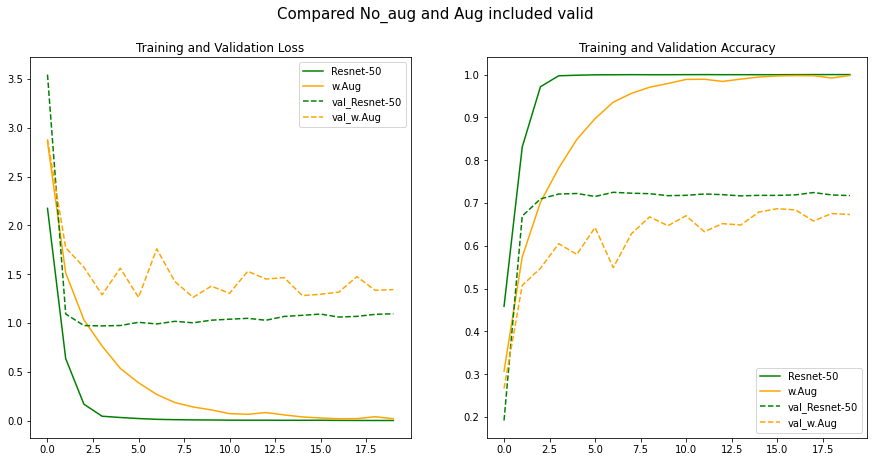

In [27]:
Compare_log('Compared No_aug and Aug included valid',history_resnet50_no_aug, history_resnet50_aug , names)

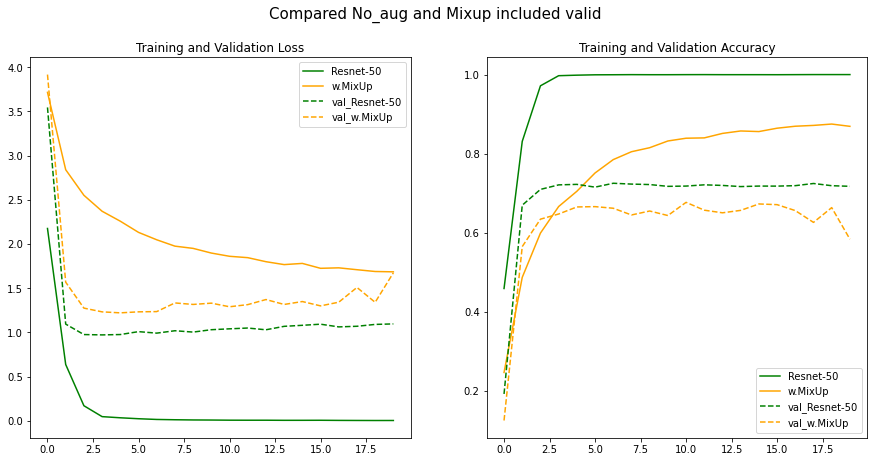

In [29]:
 Compare_log('Compared No_aug and Mixup included valid',history_resnet50_no_aug, history_resnet50_mu , [names[0],names[2]])

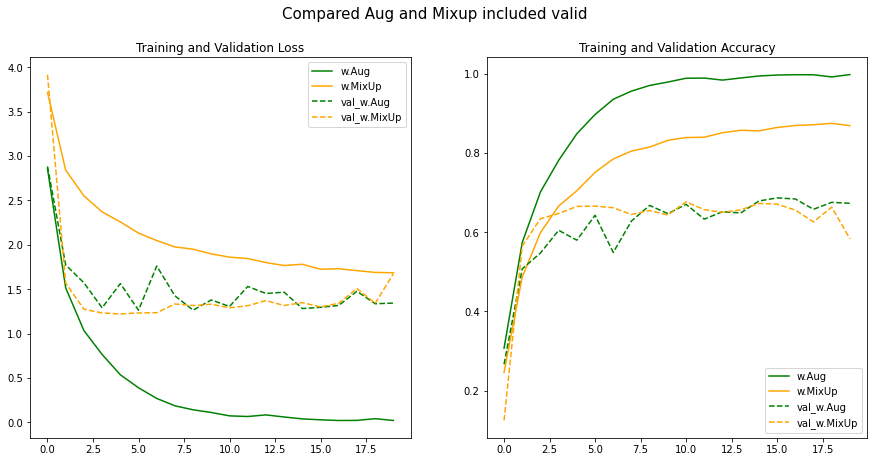

In [30]:
Compare_log('Compared Aug and Mixup included valid',history_resnet50_aug, history_resnet50_mu , [names[1],names[2]])

In [15]:
def show_log(metric, histories, names, each = False, valid = True):
    if each :
        fig, ax = plt.subplots(1,len(histories), figsize=(23,8))
        ax[0].plot(range(len(histories[0][metric])), histories[0][metric], color = colors[0], linestyle = lines[0], label = names[0])
        ax[0].plot(range(len(histories[0]['val_'+metric])), histories[0]['val_'+metric], color = colors[0], linestyle = lines[1], label = 'valid')
        ax[0].set_title(names[0])
        ax[0].legend()
        ax[1].plot(range(len(histories[1][metric])), histories[1][metric], color = colors[1], linestyle = lines[0], label = names[1])
        ax[1].plot(range(len(histories[1]['val_'+metric])), histories[1]['val_'+metric], color = colors[1], linestyle = lines[1], label = 'valid')
        ax[1].legend()
        ax[1].set_title(names[1])
        ax[2].plot(range(len(histories[2][metric])), histories[2][metric], color = colors[2], linestyle = lines[0], label = names[2])
        ax[2].plot(range(len(histories[2]['val_'+metric])), histories[2]['val_'+metric], color = colors[2], linestyle = lines[1], label = 'valid')
        ax[2].set_title(names[2])
        ax[2].set_ylim([0,1])
#         ax[3].plot(range(len(histories[3][metric])), histories[3][metric], color = colors[3], linestyle = lines[0], label = names[3])
#         ax[3].plot(range(len(histories[3]['val_'+metric])), histories[3]['val_'+metric], color = colors[3], linestyle = lines[1], label = names[3])
        ax[2].legend()
        plt.suptitle(f'Training and Validation Log for {metric}')
    else :
        plt.figure(figsize=(4,4))
        plt.plot(range(len(histories[0][metric])), histories[0][metric], label = names[0])
        plt.plot(range(len(histories[1][metric])), histories[1][metric], label = names[1])
        plt.plot(range(len(histories[2][metric])), histories[2][metric], label = names[2])
#         plt.plot(range(len(histories[3][metric])), histories[3][metric], label = names[3])
        plt.title(f'Training Log for: {metric}')
        if valid:
            plt.plot(range(len(histories[0]['val_'+metric])), histories[0]['val_'+metric], label = 'val_'+names[0])
            plt.plot(range(len(histories[1]['val_'+metric])), histories[1]['val_'+metric], label = 'val_'+names[1])
            plt.plot(range(len(histories[2]['val_'+metric])), histories[2]['val_'+metric], label = 'val_'+names[2])
#             plt.plot(range(len(histories[3]['val_'+metric])), histories[3]['val_'+metric], label = 'val_'+names[3])
    plt.legend()       
    plt.show()

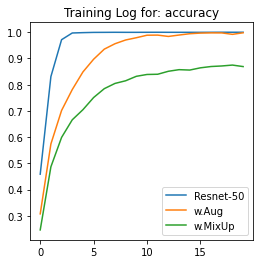

In [12]:
show_log('accuracy', histories, names, each = False, valid = False)

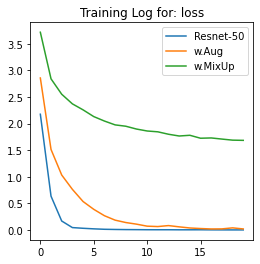

In [13]:
show_log('loss', histories, names, each = False, valid = False)

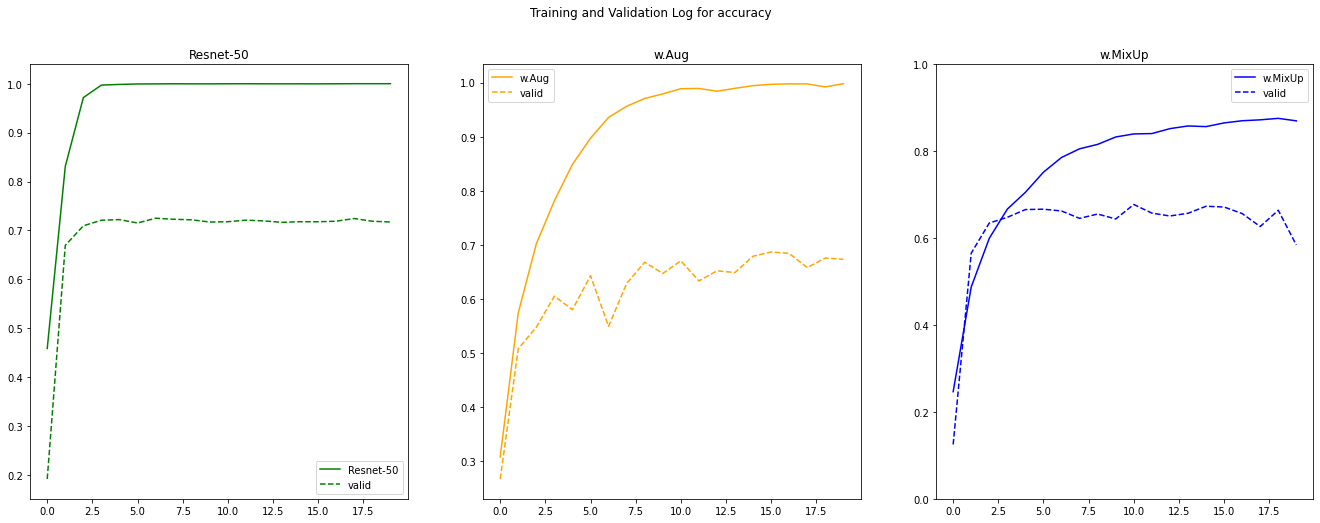

In [16]:
show_log('accuracy', histories, names, each = True)

## 회고

- CutMix와 MixUp 기법을 ResNet50에 적용시킨 결과:

-> cutmix 기법 (test_acc : 0.66) [mixup test_acc : 0.59]  


- 이 task를 하는데 최적인 augmentation 기법:
    
mixup은 accuracy가 약 0.59인 반면 cutmix를 사용했을 때 0.66이 나왔기 때문에 이 작업을 하는 데에는 cutmix가 더 낫습니다. 
그러나 plain보다 더 낮은 성적을 가지고 있기 때문에 지금의 augmentation 방법이 최적은 아닌 것 같습니다. 



- 기법을 달리 함으로써 달라지는 결과 분석:
    
적합한 데이터셋 혹은 기법이 제대로 작동했는지에 대한 점검이 필요하다. 

